# Raiffeisen - Classification Random Forest

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

pd.options.display.max_columns = 400

/usr/local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Functions

In [2]:
# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")
    return plt

In [3]:
# Plot validation curve
def plot_validation_curve(estimator, title, X, y, param_name, param_range, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), xscale='linear'):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name, param_range, cv)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(param_range, train_mean, color='r', marker='o', markersize=5, label='Training score')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='r')
    plt.plot(param_range, test_mean, color='g', linestyle='--', marker='s', markersize=5, label='Validation score')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='g')
    plt.grid() 
    plt.xscale(xscale)
    plt.legend(loc='best') 
    plt.xlabel('Parameter') 
    plt.ylabel('Score') 
    plt.ylim(ylim)

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          figsize=(5,5)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label',
           xlim=(-0.5, 2.5),
           ylim=(2.5, -0.5))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Load data

In [5]:
%%time

df = pd.read_csv('RFB - Merged Data.csv', index_col=0)

df.shape

CPU times: user 17.1 s, sys: 3.6 s, total: 20.7 s
Wall time: 18.1 s


(555844, 316)

## Feature selection

In [6]:
cl_columns = [
    'CL_DB_TXN_CNT_m1',
    'CL_DB_TXN_AMT_m1',
    'CL_CR_TXN_CNT_m1',
    'CL_CR_TXN_AMT_m1',
    'CL_EOM_BAL_AMT_m1',
    'CL_AVG_BAL_AMT_m1',
    'CL_ACC_USED_CNT_m1',
    'CL_TOT_TXN_CNT_m1',
    'CL_TOT_TXN_AMT_m1',
    'CL_ACCT_OPENED_CNT',
    'CL_ACCT_CLOSED_CNT',
    'CL_MATURITY_MTH',
    'CL_MAX_TENURE_MTH',
    'CL_MIN_TENURE_MTH',
    'CL_MTH_SINCE_LAST_OPEN',
    'CL_FLG_EVER',
    'CL_FLG_m1',
    'CL_ACCT_CNT_m1',
    'CL_ACCT_OPEN_CNT_m1',
    'CL_ACCT_CLOSE_CNT_m1',
    'CL_MTH_SINCE_LAST_OPEN_MISSING',
    'CL_MATURITY_MTH_MISSING'
]
incl_columns = [
    'CUSTOMER_RK',
    'FIRST_OPEN_PRODUCT',
    'CITY',
#     'MOBILE_FLG',
    'EMAIL_FLG',
#     'IS_SEGMENT_CD',
    'BRANCH_CD',
#     'REGION_CD',
    'GEO_REGION_CD',
    'AGE_AT_ANALYSIS_MTH_CNT',
    'GENDER_CD',
    'DC_MIX',
    'CC_MIX',
    'ROL_flg_m1',
    'MOB_ACTIVE',
    'BizSeg',
    'month',
    'month_od',
    'month_do',
    'mBanking_logs_m1',
    'eBanking_logs_m1',
    'MARITAL_STATUS',
    'Education_level',
    'RESIDENCE_STATUS',
    'EMPLOYMENT_TYPE',
    'cpi_consumer',
    'cpi_excluding',
    'cash_loan',
    'grad',
    'F',
    'P',
    'R',
    'broj_prijava',
    'broj_obveznika'
]
# ds = df[df.DAYS_SINCE_FIRST_ACCOUNT_OPEN<180].drop(cl_columns, axis=1)
ds = df[df.DAYS_SINCE_FIRST_ACCOUNT_OPEN<180][incl_columns]
ds.shape

(219403, 31)

In [7]:
ds.set_index(['CUSTOMER_RK', 'month'], inplace=True)
ds.head()

FIRST_OPEN_PRODUCT                  CITY  EMAIL_FLG  \
CUSTOMER_RK month                                                        
427759      201506                LEN  beograd-novi beograd          0   
            201505                LEN  beograd-novi beograd          0   
            201507                LEN  beograd-novi beograd          0   
            201503                LEN  beograd-novi beograd          0   
            201508                LEN  beograd-novi beograd          0   

                    BRANCH_CD GEO_REGION_CD  AGE_AT_ANALYSIS_MTH_CNT  \
CUSTOMER_RK month                                                      
427759      201506        161     BEOGRAD 1                     62.0   
            201505        161     BEOGRAD 1                     62.0   
            201507        161     BEOGRAD 1                     62.0   
            201503        161     BEOGRAD 1                     62.0   
            201508        161     BEOGRAD 1                     63.0   

                   GENDER_CD   DC_MIX   CC_MIX  ROL_flg_m1  MOB_ACTIVE  \
CUSTOMER_RK month                                                        
427759      201506         F  Unknown  Unknown           0         4.0   
            201505         F  Unknown  Unknown           0         3.0   
            201507         F  Unknown  Unknown           0         5.0   
            201503         F  Unknown  Unknown           0         1.0   
            201508         F  Unknown  Unknown           0         6.0   

                     BizSeg  month_od  month_do  mBanking_logs_m1  \
CUSTOMER_RK month                                                   
427759      201506  Webovci    201503    201609                 0   
            201505  Webovci    201503    201609                 0   
            201507  Webovci    201503    201609                 0   
            201503  Webovci    201503    201609                 0   
            201508  Webovci    201503    201609                 0   

                    eBanking_logs_m1 MARITAL_STATUS       Education_level  \
CUSTOMER_RK month                                                           
427759      201506                 0        Married  2. Elementary School   
            201505                 0        Married  2. Elementary School   
            201507                 0        Married  2. Elementary School   
            201503                 0        Married  2. Elementary School   
            201508                 0        Married  2. Elementary School   

                   RESIDENCE_STATUS EMPLOYMENT_TYPE  cpi_consumer  \
CUSTOMER_RK month                                                   
427759      201506        Ownership      Unemployed           1.9   
            201505        Ownership      Unemployed           1.5   
            201507        Ownership      Unemployed           1.0   
            201503          Renting      Unemployed           1.9   
            201508        Ownership      Unemployed           2.1   

                    cpi_excluding       cash_loan                  grad  \
CUSTOMER_RK month                                                         
427759      201506            0.6  nije u prvih 6  beograd-novi beograd   
            201505            0.1  nije u prvih 6  beograd-novi beograd   
            201507            0.5  nije u prvih 6  beograd-novi beograd   
            201503            0.0  nije u prvih 6  beograd-novi beograd   
            201508            0.2  nije u prvih 6  beograd-novi beograd   

                          F       P      R broj_prijava broj_obveznika  
CUSTOMER_RK month                                                       
427759      201506  163.517  18.304  6.614      122,769        100,725  
            201505  163.517  18.304  6.614      122,769        100,725  
            201507  163.517  18.304  6.614      122,769        100,725  
            201503  163.517  18.304  6.614      122,769        100,725  
    

## Feature transformation

In [11]:
le = LabelEncoder()

# ds.PD_MIX_ACTIVE_m1 = le.fit_transform(ds.PD_MIX_ACTIVE_m1)
ds.FIRST_OPEN_PRODUCT = le.fit_transform(ds.FIRST_OPEN_PRODUCT)
# ds.FIRST_CLOSED_PRODUCT_6MTH = le.fit_transform(ds.FIRST_CLOSED_PRODUCT_6MTH)
# ds.LAST_OPEN_PRODUCT = le.fit_transform(ds.LAST_OPEN_PRODUCT)
# ds.LAST_CLOSED_PRODUCT = le.fit_transform(ds.LAST_CLOSED_PRODUCT)
# ds.PD_MIX_EVER = le.fit_transform(ds.PD_MIX_EVER)
ds.CITY = le.fit_transform(ds.CITY)
# ds.IS_SEGMENT_CD = le.fit_transform(ds.IS_SEGMENT_CD)
# ds.REGION_CD = le.fit_transform(ds.REGION_CD)
ds.GEO_REGION_CD = le.fit_transform(ds.GEO_REGION_CD)
ds.GENDER_CD = le.fit_transform(ds.GENDER_CD)
ds.DC_MIX = le.fit_transform(ds.DC_MIX)
ds.CC_MIX = le.fit_transform(ds.CC_MIX)
ds.BizSeg = le.fit_transform(ds.BizSeg)
ds.MARITAL_STATUS = le.fit_transform(ds.MARITAL_STATUS)
ds.Education_level = le.fit_transform(ds.Education_level)
ds.RESIDENCE_STATUS = le.fit_transform(ds.RESIDENCE_STATUS)
ds.EMPLOYMENT_TYPE = le.fit_transform(ds.EMPLOYMENT_TYPE)
ds.cash_loan = le.fit_transform(ds.cash_loan)
ds.grad = le.fit_transform(ds.grad)
ds.broj_prijava = le.fit_transform(ds.broj_prijava)
ds.broj_obveznika = le.fit_transform(ds.broj_obveznika)

In [12]:
y = ds['cash_loan']
X = ds[ds.loc[:, ds.columns != 'cash_loan'].columns]

In [13]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

## Random Forest Classifier

Used Grid Search to select best parameters

In [15]:
estimator = RandomForestClassifier(
    n_estimators=50,
    max_depth=50,
    random_state=0
)

param_grid = {
    'max_depth': [25, 50],
    'n_estimators':  [250, 500]
}

clf = GridSearchCV(
    estimator,
    param_grid,
    scoring='f1_micro',
    verbose=4,
    n_jobs=-1,
    cv=3
)

clf.fit(X_train, y_train)

best_estimator = clf.best_estimator_
best_score = clf.best_score_
best_params = clf.best_params_

print("Best score: %.4f %%" % best_score)
print("Best params:", best_params)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] n_estimators=150, max_depth=25 ..................................
[CV] n_estimators=150, max_depth=25 ..................................
[CV] n_estimators=150, max_depth=25 ..................................
[CV]  n_estimators=150, max_depth=25, score=0.9941715379619185, total=  23.0s
[CV]  n_estimators=150, max_depth=25, score=0.994120462159021, total=  23.5s
[CV]  n_estimators=150, max_depth=25, score=0.9942230122376428, total=  23.8s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.1s finished


Best score: 0.9942 %
Best params: {'n_estimators': 150, 'max_depth': 25}


### Cross validation score

In [16]:
%%time

scores = cross_val_score(best_estimator, X_train, y_train, cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.995 +/- 0.000
CPU times: user 1.16 s, sys: 644 ms, total: 1.8 s
Wall time: 53.8 s


### Learning curve

CPU times: user 4.84 s, sys: 756 ms, total: 5.59 s
Wall time: 2min 8s


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py'>

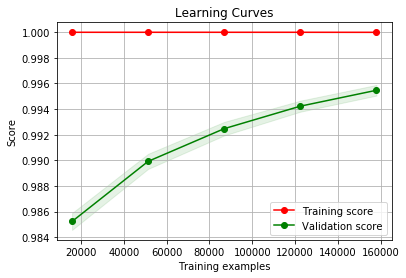

In [17]:
%%time

title = "Learning Curves"
cv = 10
plot_learning_curve(best_estimator, title, X_train, y_train, cv=cv, n_jobs=-1);

### Test predictions

In [18]:
y_pred = best_estimator.predict(X_test)

In [19]:
score = best_estimator.score(X_test, y_test)
print("Score: %.4f %%" % score)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f %%" % (accuracy * 100.0))

Score: 0.9955 %
Accuracy: 99.55 %


### Plot confusion matrix

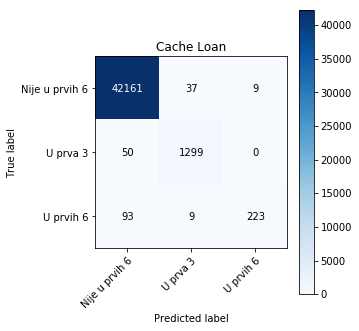

In [20]:
class_names = np.array(['Nije u prvih 6', 'U prva 3', 'U prvih 6'])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Cache Loan')

plt.show()

### Feature importance

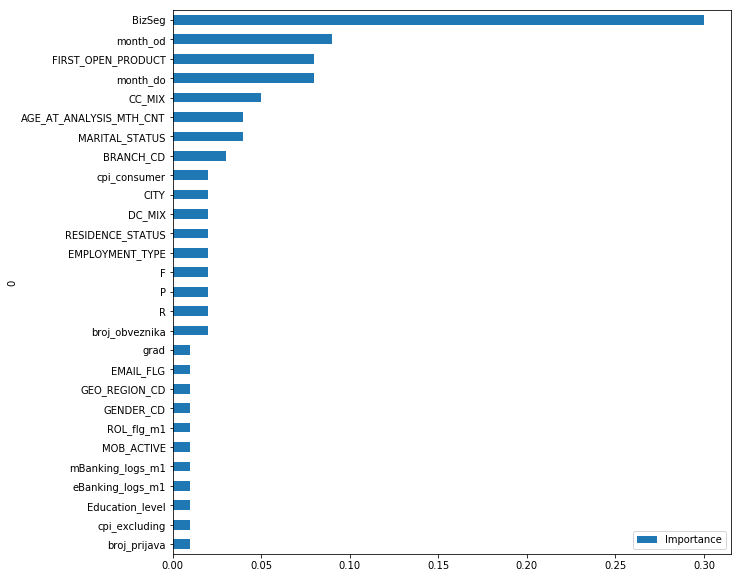

In [21]:
feature_list = list(ds.loc[:, ds.columns != 'cash_loan'].columns)
importances = list(best_estimator.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
pd.DataFrame(feature_importances) \
.set_index(0) \
.rename(columns={1:'Importance'}) \
.sort_values('Importance', ascending=True) \
.plot.barh(figsize=(10,10))